In [2]:
from units import *
import matplotlib.pyplot as plt
from astrometry_sim import QuasarSim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
sim = QuasarSim(sh_m_frac=1, m_delta=1e9*M_s, c200_delta=100000., verbose=True, save=False, save_tag='log10M_11_mfrac_0.5_mc_0',sh_distrib='Aq1')

100%|██████████| 1385/1385 [00:21<00:00, 65.79it/s]


In [19]:
# sim.update_sample(sh_m_frac=1, m_delta=1e6*M_s, c200_delta=100000.)

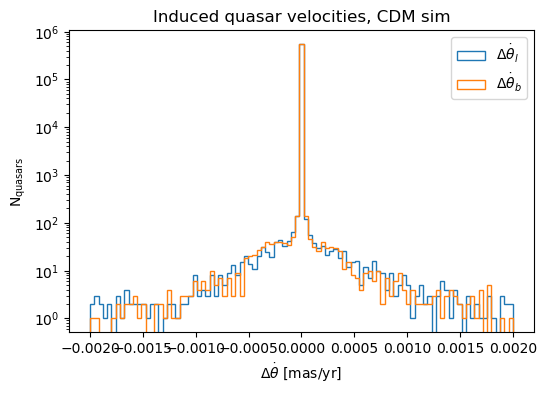

In [12]:
plt.figure(figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
lims = 2e-3
bins = np.linspace(-lims,lims,100)
plt.hist(sim.mu_qsrs[:,0]/1e-3,bins = bins, histtype='step', label='$\Delta\dot\\theta_l$');
plt.hist(sim.mu_qsrs[:,1]/1e-3,bins = bins, histtype='step', label='$\Delta\dot\\theta_b$');
plt.xlabel("$\Delta\dot\\theta$ [mas/yr]")
plt.ylabel("N$_\\mathrm{quasars}$")
plt.title('Induced quasar velocities, CDM sim')
plt.yscale("log")
plt.legend()